In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import logging

In [2]:
from pandas import IndexSlice as idx

In [3]:
from backtesting import perform_backtest, PortfolioBacktest
from sharpe import calc_sharpe

In [4]:
source_folder = 'files'

# Constants

In [5]:
capital = 1e6

# Reading data

## VFINX

In [6]:
with open(f'{source_folder}/VFINX.json', 'r') as file:
    _vfinx = json.load(file)

vfinx = pd.DataFrame.from_dict(_vfinx).copy()
vfinx.index = pd.Series(pd.to_numeric(vfinx.index)).apply(lambda _date: datetime.fromtimestamp(_date * 1e-3))
vfinx.sort_index(ascending=True, inplace=True)

vfinx.index = vfinx.index.tz_localize(None).floor(freq='D')

In [7]:
vfinx.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close
count,8833.000000,8833.000000,8833.000000,8833.000000,8833.0,8833.000000,8833.0,8833.000000
mean,91.410905,91.410905,91.410905,91.410905,0.0,0.008916,0.0,19.925365
std,74.364430,74.364430,74.364430,74.364430,0.0,0.081741,0.0,8.501164
min,9.693998,9.693998,9.693998,9.693998,0.0,0.000000,0.0,9.140000
25%,26.499744,26.499744,26.499744,26.499744,0.0,0.000000,0.0,14.090000
50%,77.715508,77.715508,77.715508,77.715508,0.0,0.000000,0.0,18.130000
75%,107.777855,107.777855,107.777855,107.777855,0.0,0.000000,0.0,23.250000
max,355.809998,355.809998,355.809998,355.809998,0.0,1.390000,0.0,150.190000


In [8]:
vfinx['Volume'].value_counts()

0    8833
Name: Volume, dtype: int64

In [9]:
vfinx['Dividends'].value_counts()

0.000    8692
0.180      15
0.220      12
0.350       5
0.300       5
         ... 
0.520       1
0.480       1
0.490       1
0.530       1
1.311       1
Name: Dividends, Length: 91, dtype: int64

In [10]:
vfinx['Stock Splits'].value_counts()

0    8833
Name: Stock Splits, dtype: int64

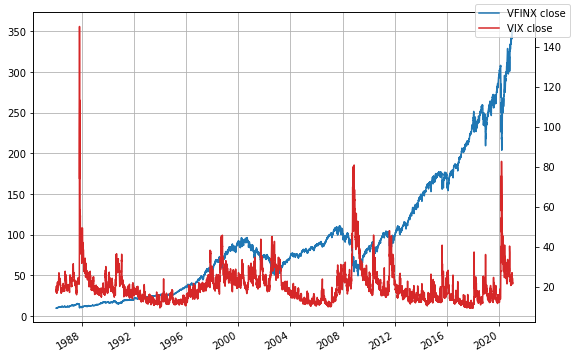

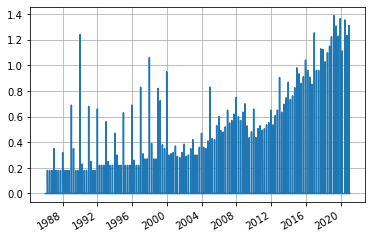

In [11]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

vfinx['Close'].plot(ax=ax1, label='VFINX close')
vfinx['VIX_Close'].plot(ax=ax2, label='VIX close', color='tab:red')

fig.legend()
ax1.grid()
# ax2.grid()
fig.tight_layout()
plt.show()

vfinx['Dividends'].plot()
plt.grid()
plt.show()

In [12]:
vfinx

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close
1986-01-02,9.969467,9.969467,9.969467,9.969467,0,0.0,0,18.07
1986-01-03,10.035052,10.035052,10.035052,10.035052,0,0.0,0,17.96
1986-01-06,10.030688,10.030688,10.030688,10.030688,0,0.0,0,17.05
1986-01-07,10.179354,10.179354,10.179354,10.179354,0,0.0,0,17.39
1986-01-08,9.899508,9.899508,9.899508,9.899508,0,0.0,0,19.97
...,...,...,...,...,...,...,...,...
2021-01-15,347.940002,347.940002,347.940002,347.940002,0,0.0,0,24.34
2021-01-19,350.779999,350.779999,350.779999,350.779999,0,0.0,0,23.24
2021-01-20,355.670013,355.670013,355.670013,355.670013,0,0.0,0,21.58
2021-01-21,355.809998,355.809998,355.809998,355.809998,0,0.0,0,21.32


In [13]:
dates = vfinx.index
securities = ['VFINX']

## 10Y US Notes

In [14]:
ust = pd.read_csv('files/ust_10y_yields_hist.csv')
ust['Date'] = pd.to_datetime(ust['Date'])
ust.set_index('Date', inplace=True)
ust.sort_index(ascending=True, inplace=True)

In [15]:
ust['Close'].describe()

count    9061.000000
mean        4.727160
std         2.321428
min         0.499000
25%         2.624000
50%         4.564000
75%         6.537000
max        10.230000
Name: Close, dtype: float64

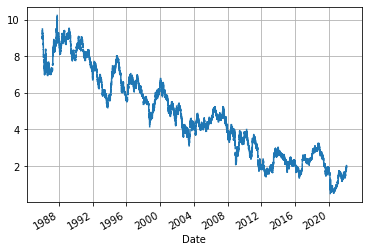

In [16]:
ust['Close'].plot()

plt.grid()
plt.show()

# Countering VIX strategy

# Buy & hodl strategy

## Running strategy

In [17]:
# logging.basicConfig(level=logging.DEBUG)

In [18]:
quotes = vfinx[['Close']].copy()
quotes.columns = securities

ini_positions = None
max_loan = 0

pb = PortfolioBacktest(securities=securities,
                       dates=dates,
                       quotes=quotes,
                       capital=capital,
                       ini_positions=ini_positions,
                       max_loan=max_loan)

In [19]:
%%time

pb.run_strategy()

CPU times: user 17.6 s, sys: 110 ms, total: 17.7 s
Wall time: 18.4 s


In [20]:
pb.get_combined_df()

attr             price      weight                            #                \
sec              VFINX cash  VFINX          cash          VFINX          cash   
1986-01-02    9.969467    1    0.0  1.000000e+00       0.000000  1.000000e+06   
1986-01-03   10.035052    1    1.0  1.156545e-16  100306.263478  1.164153e-10   
1986-01-06   10.030688    1    1.0  1.157048e-16  100306.263478  1.164153e-10   
1986-01-07   10.179354    1    1.0  1.140150e-16  100306.263478  1.164153e-10   
1986-01-08    9.899508    1    1.0  1.172380e-16  100306.263478  1.164153e-10   
...                ...  ...    ...           ...            ...           ...   
2021-01-15  347.940002    1    1.0  3.335629e-18  100306.263478  1.164153e-10   
2021-01-19  350.779999    1    1.0  3.308623e-18  100306.263478  1.164153e-10   
2021-01-20  355.670013    1    1.0  3.263133e-18  100306.263478  1.164153e-10   
2021-01-21  355.809998    1    1.0  3.261850e-18  100306.263478  1.164153e-10   
2021-01-22  354.739990    1    1.0  3.271688e-18  100306.263478  1.164153e-10   

attr               value                    rebalance             \
sec                VFINX          cash          VFINX       cash   
1986-01-02  0.000000e+00  1.000000e+06            NaN        NaN   
1986-01-03  1.006579e+06  1.164153e-10  100306.263478 -1000000.0   
1986-01-06  1.006141e+06  1.164153e-10            NaN        NaN   
1986-01-07  1.021053e+06  1.164153e-10            NaN        NaN   
1986-01-08  9.929826e+05  1.164153e-10            NaN        NaN   
...                  ...           ...            ...        ...   
2021-01-15  3.490056e+07  1.164153e-10            NaN        NaN   
2021-01-19  3.518543e+07  1.164153e-10            NaN        NaN   
2021-01-20  3.567593e+07  1.164153e-10            NaN        NaN   
2021-01-21  3.568997e+07  1.164153e-10            NaN        NaN   
2021-01-22  3.558264e+07  1.164153e-10            NaN        NaN   

attr       rebalance price                nav  
sec                  VFINX cash                
1986-01-02             NaN    1  1.000000e+06  
1986-01-03        9.969467    1  1.006579e+06  
1986-01-06             NaN    1  1.006141e+06  
1986-01-07             NaN    1  1.021053e+06  
1986-01-08             NaN    1  9.929826e+05  
...                    ...  ...           ...  
2021-01-15             NaN    1  3.490056e+07  
2021-01-19             NaN    1  3.518543e+07  
2021-01-20             NaN    1  3.567593e+07  
2021-01-21             NaN    1  3.568997e+07  
2021-01-22             NaN    1  3.558264e+07  

[8833 rows x 13 columns]

## Evaluating aggregate portfolio results

In [21]:
annualization_factor = 360

portf_res = perform_backtest(pb.nav, ust['Close'] / 100, risk_free_annualized=True,
                             annualization_factor=annualization_factor).copy()

In [22]:
(portf_res['total return'].iloc[-1] + 1) ** (1 / 35) - 1

0.10744225828819354

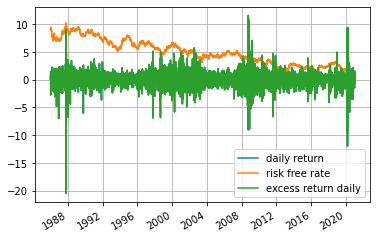

In [23]:
_cols = ['daily return', 'risk free rate', 'excess return daily']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

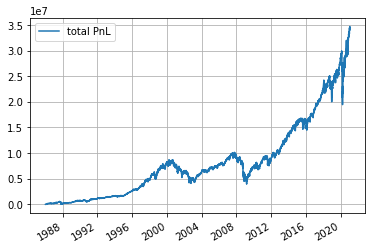

In [24]:
_cols = ['total PnL']
_data = portf_res[_cols]
_data.plot()

plt.grid()
plt.show()

### Sharpe

In [25]:
calc_sharpe(portf_res['excess return'].mean(), portf_res['excess return'].std(), multiply_by=252 ** .5)

0.1828539744781804

In [26]:
calc_sharpe(portf_res['excess return daily'].mean(), portf_res['excess return daily'].std(), multiply_by=252 ** .5)

0.4585805403302315